<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Demo-running-eazy-py" data-toc-modified-id="Demo-running-eazy-py-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demo running eazy-py</a></span><ul class="toc-item"><li><span><a href="#Setup-things" data-toc-modified-id="Setup-things-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup things</a></span></li><li><span><a href="#HDFN-catalog" data-toc-modified-id="HDFN-catalog-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>HDFN catalog</a></span></li><li><span><a href="#ZFOURGE-catalog" data-toc-modified-id="ZFOURGE-catalog-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>ZFOURGE catalog</a></span></li><li><span><a href="#Initialize-eazy.photoz.PhotoZ-object" data-toc-modified-id="Initialize-eazy.photoz.PhotoZ-object-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Initialize <code>eazy.photoz.PhotoZ</code> object</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Iterative-zeropoint-corrections" data-toc-modified-id="Iterative-zeropoint-corrections-1.4.0.1"><span class="toc-item-num">1.4.0.1&nbsp;&nbsp;</span>Iterative zeropoint corrections</a></span></li><li><span><a href="#Now-fit-the-whole-catalog" data-toc-modified-id="Now-fit-the-whole-catalog-1.4.0.2"><span class="toc-item-num">1.4.0.2&nbsp;&nbsp;</span>Now fit the whole catalog</a></span></li></ul></li></ul></li><li><span><a href="#zout-properties" data-toc-modified-id="zout-properties-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span><code>zout</code> properties</a></span></li></ul></li><li><span><a href="#Save-/-restore-state-with-HDF5" data-toc-modified-id="Save-/-restore-state-with-HDF5-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Save / restore state with HDF5</a></span><ul class="toc-item"><li><span><a href="#Initialize-from-HDF5" data-toc-modified-id="Initialize-from-HDF5-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize from HDF5</a></span></li><li><span><a href="#Tool-for-visualizing-SEDs-straight-from-HDF5" data-toc-modified-id="Tool-for-visualizing-SEDs-straight-from-HDF5-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tool for visualizing SEDs straight from HDF5</a></span></li></ul></li><li><span><a href="#Visualization-tool" data-toc-modified-id="Visualization-tool-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualization tool</a></span><ul class="toc-item"><li><span><a href="#static-view" data-toc-modified-id="static-view-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>static view</a></span></li></ul></li></ul></div>

# Demo running eazy-py

In [1]:
%matplotlib inline

## Setup things 

For running on cloud environments, e.g, 

<p style="float:left; margin:5px"> <a href="https://colab.research.google.com/github/gbrammer/eazy-py/blob/master/docs/examples/HDFN-demo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="float:left"/> </a> </p>

<p style="display:inline-block; margin:5px"> <a href="https://mybinder.org/v2/gh/gbrammer/eazy-py/HEAD?filepath=docs%2Fexamples%2FHDFN-demo.ipynb"><img src="https://mybinder.org/badge_logo.svg" /> </a> </p>


In [2]:
# environment installation for hosted notebooks
# (e.g., mybinder, GoogleCollab)
import os
import sys

orig_wd = os.getcwd()

try:
    import eazy
    HAS_EAZY = True
except:
    HAS_EAZY = False

# mybinder
if ('jovyan' in orig_wd):
    if not HAS_EAZY:
        print('Install on /home/jovyan')

        os.chdir('/home/jovyan')
        ! {sys.executable} -m pip install .
            
    try:
        import grizli
    except:
        ! {sys.executable} -m pip install grizli

# Google collab
if ('/content' in orig_wd):
    if not HAS_EAZY:
        print('Install on /content (Google Collab')

        ! {sys.executable} -m pip install eazy

        os.chdir(orig_wd)

    try:
        import grizli
    except:
        ! {sys.executable} -m pip install grizli
                
try:
    import grizli
except ImportError:
    ! {sys.executable} -m pip install grizli

try:
    import astroquery
except ImportError:
    ! {sys.executable} -m pip install astroquery

try:
    import pandas
except ImportError:
    ! {sys.executable} -m pip install pandas

try:
    import lxml
except ImportError:
    ! {sys.executable} -m pip install install lxml

In [3]:
# Now download templates etc.
import eazy
if not os.path.exists(os.path.join(eazy.utils.DATA_PATH, 'templates')):
    eazy.fetch_eazy_photoz()


In [4]:
# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect','grizli']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))


Fri Oct 25 14:58:35 2024

3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:20) [Clang 17.0.6 ]

               numpy : 2.0.2
               scipy : 1.13.1
          matplotlib : 3.9.2
             astropy : 6.1.4
                eazy : 0.7.5.dev2+g292302a.d20241025
            prospect : 1.4.0
              grizli : 1.12.8


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

# # Symlink templates & filters from the eazy-code repository
# try:
#     print('EAZYCODE = '+os.getenv('EAZYCODE'))
# except:
#     pass

# if not os.path.exists('templates'):
#     eazy.symlink_eazy_inputs() 

In [6]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

## HDFN catalog

Default parameters are stored in the file `eazy/data/zphot.param.default` in the repository.

Parameter that differ from defaults can be provided in a dictionary as follows.

In [7]:
from eazy.utils import DATA_PATH

params = {}
params['CATALOG_FILE'] = os.path.join(DATA_PATH, 'hdfn_fs99', 'hdfn_fs99_eazy.cat')

params['MAIN_OUTPUT_FILE'] = 'hdfn.eazypy'

# Galactic extinction
params['MW_EBV'] = 0.0103
params['CAT_HAS_EXTCORR'] = True

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 28 # K
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

params['IGM_SCALE_TAU'] = 1.0

translate_file = os.path.join(DATA_PATH, 'hdfn_fs99', 'zphot.translate')


## ZFOURGE catalog

Use the [ZFOURGE](https://sites.google.com/site/zfourge/) CDFS catalog from Straatman et al., pulled from [Vizier](https://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/ApJ/830/51/zf_cdfs).

In [8]:
import pandas as pd
from grizli.catalog import query_tap_catalog

# field = 'cdfs'
field = 'uds'

radec = {'cdfs':(53.0, -27.9), 
         'uds':(34.3, -5.3)}

# Vizier Table
# https://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/ApJ/830/51/zf_cdfs
db = f'"J/ApJ/830/51/zf_{field}"'

# Bright mag to limit catalog size
MAX_KMAG = 22.5

# Get table from Vizier
cat_name = f'zfourge.{field}.zspec.vizier.csv'

if not os.path.exists(cat_name):
    zf = query_tap_catalog(*radec[field], radius=60, db=db, vizier=True, 
                       extra=f" AND (zspec > 0 OR FKsall > {10**(-0.4*(MAX_KMAG-25))})", verbose=True)

    print(f'\nFound {len(zf)} objects in {db}')

    zf.write(cat_name, overwrite=True)
else:
    zf = grizli.utils.read_catalog(cat_name)
    
print('zFOURGE catalog: ', cat_name)
    

zFOURGE catalog:  zfourge.uds.zspec.vizier.csv


In [9]:
#### Update parameters

# Predefined translate file
trans_name = f'zfourge.{field}.vizier.translate.csv'
csv_trans = pd.read_csv(f'https://erda.ku.dk/vgrid/Gabriel%20Brammer/Catalogs/{trans_name}')
csv_trans.to_csv(trans_name, index=False)

# New parameters
params['MW_EBV'] = eazy.utils.get_irsa_dust(np.nanmedian(zf['ra']), np.nanmedian(zf['dec']))

params['CATALOG_FILE'] = cat_name
params['PRIOR_ABZP'] = 25
params['CATALOG_FORMAT'] = 'csv'
params['PRIOR_FILTER'] = 255

params['TEMPLATES_FILE'] = 'templates/spline_templates_v2/tweak_spline.param'

params['MAIN_OUTPUT_FILE'] = f'zfourge.{field}'

# params['TEMPLATES_FILE'] = 'templates/sfhz/agn_blue_sfhz_13.param'

params['SYS_ERR'] = 0.03

params['Z_MAX'] = 12.
params['Z_STEP'] = 0.005

translate_file = trans_name

## Initialize `eazy.photoz.PhotoZ` object

In [10]:
self = eazy.photoz.PhotoZ(
    param_file=None,
    translate_file=translate_file,
    zeropoint_file=None,
    params=params,
    load_prior=True,
    load_products=False
)

Read default param file: /Users/gbrammer/miniconda3/envs/py310-eazy/lib/python3.10/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: zfourge.uds.zspec.vizier.csv
   >>> NOBJ = 3207
F8_0 e_F8_0 ( 21): IRAC/irac_tr4_2004-08-09.dat
F5_8 e_F5_8 ( 20): IRAC/irac_tr3_2004-08-09.dat
F4_5 e_F4_5 ( 19): IRAC/irac_tr2_2004-08-09.dat
F3_6 e_F3_6 ( 18): IRAC/irac_tr1_2004-08-09.dat
FKs e_FKs (255): FOURSTAR/Ks_cam_optics_sky.txt
FKsHI e_FKsHI (269): VLT/hawki_k_ETC.dat
FJ1 e_FJ1 (249): FOURSTAR/J1_cam_optics_sky.txt
FJ2 e_FJ2 (250): FOURSTAR/J2_cam_optics_sky.txt
FJ3 e_FJ3 (251): FOURSTAR/J3_cam_optics_sky.txt
FHs e_FHs (254): FOURSTAR/Hshort_cam_optics_sky.txt
FHl e_FHl (253): FOURSTAR/Hlong_cam_optics_sky.txt
Fu e_Fu ( 88): megaprime/cfht_mega_u_cfh9301.dat
FB e_FB (122): UKIDSS/B_qe.txt
FV e_FV ( 79): COSMOS/SUBARU_filter_V.txt
FR e_FR (123): UKIDSS/R_qe.txt
Fi e_Fi (124): UKIDSS/i_qe.txt
Fz e_Fz (125): UKIDSS/z_qe.txt
FY e_FY (266): VLT/hawki_y_ETC.dat
FJ e_FJ (263): UKIDSS/Table0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42it/s]


Template   0: tweak_spline_age0.01_av0.0.fits (NZ=26).
Template   1: tweak_spline_age0.01_av0.5.fits (NZ=26).
Template   2: tweak_spline_age0.03_av0.0.fits (NZ=26).
Template   3: tweak_spline_age0.03_av0.5.fits (NZ=26).
Template   4: tweak_spline_age0.03_av1.0.fits (NZ=26).
Template   5: tweak_spline_age0.03_av2.0.fits (NZ=26).
Template   6: tweak_spline_age0.03_av3.0.fits (NZ=26).
Template   7: tweak_spline_age0.03_av5.0.fits (NZ=26).
Template   8: tweak_spline_age0.16_av0.0.fits (NZ=1).
Template   9: tweak_spline_age0.16_av1.0.fits (NZ=1).
Template  10: tweak_spline_age0.16_av2.0.fits (NZ=1).
Template  11: tweak_spline_age0.67_av0.0.fits (NZ=1).
Template  12: tweak_spline_age0.67_av1.0.fits (NZ=1).
Template  13: tweak_spline_age0.67_av2.0.fits (NZ=1).
Template  14: tweak_spline_age1.75_av0.0.fits (NZ=1).
Template  15: tweak_spline_age1.75_av1.0.fits (NZ=1).
Template  16: tweak_spline_age3.68_av0.0.fits (NZ=1).
Template  17: tweak_spline_age3.68_av1.0.fits (NZ=1).
Template  18: tweak_

511it [00:00, 1763.20it/s]


### Iterative zeropoint corrections

Iteration:  0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:36<00:00, 13.88it/s]


Compute best fits
fit_best: 1.1 s (n_proc=1,  NOBJ=3149)
Fit 38.2 s (n_proc=8, NOBJ=3203)
Iterative correction - zeropoint / template
Iteration:  1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:36<00:00, 13.94it/s]


Compute best fits
fit_best: 1.1 s (n_proc=1,  NOBJ=3150)
Fit 37.9 s (n_proc=8, NOBJ=3203)
Iterative correction - zeropoint / template
Iteration:  2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:36<00:00, 13.95it/s]


Compute best fits
fit_best: 1.1 s (n_proc=1,  NOBJ=3144)
Fit 38.0 s (n_proc=8, NOBJ=3203)
Iterative correction - zeropoint / template


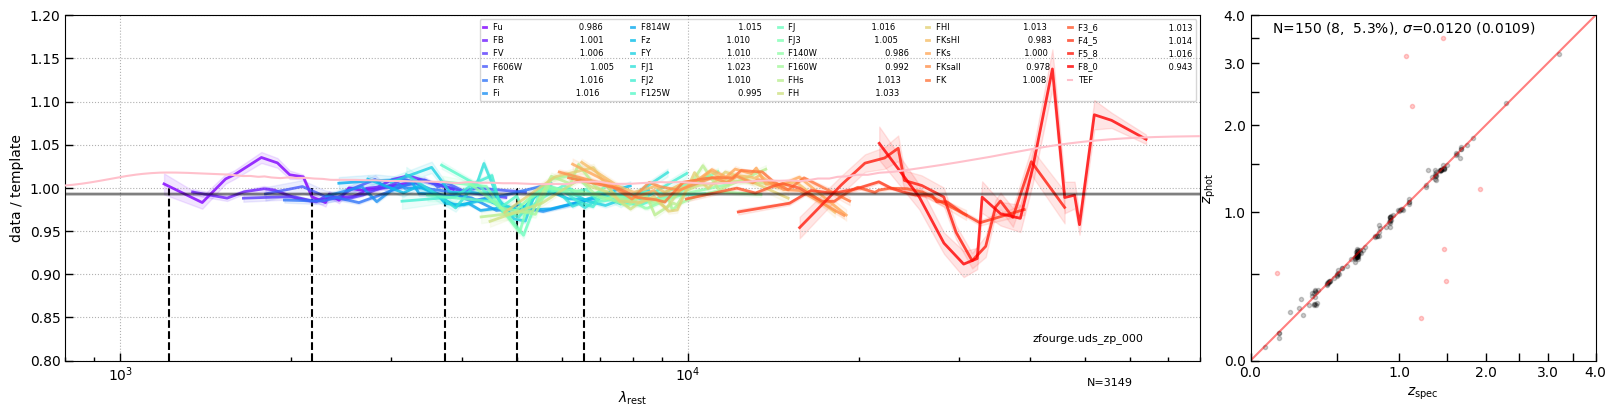

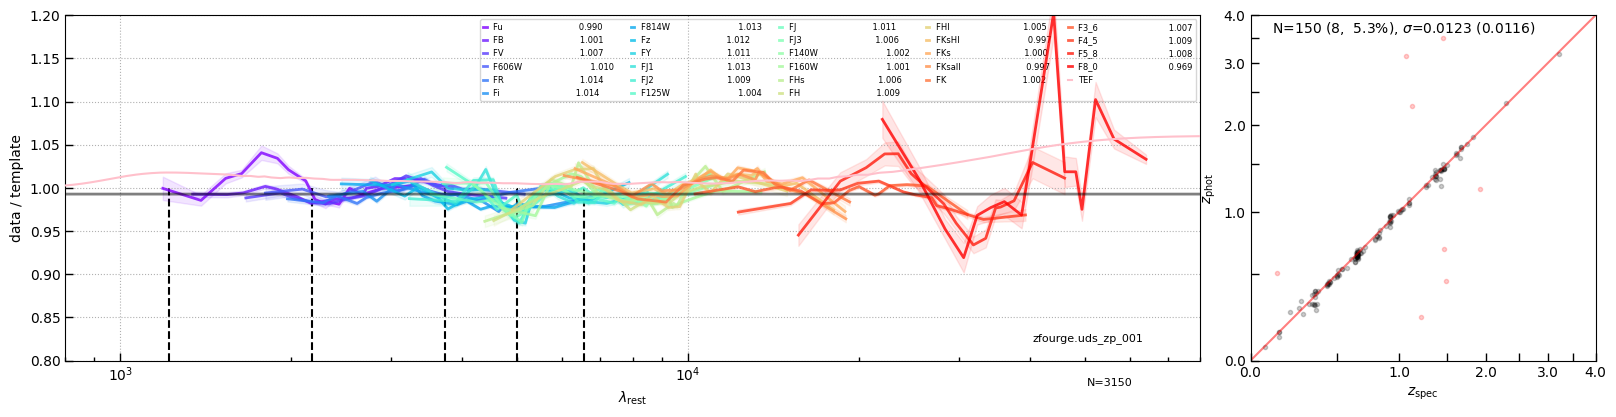

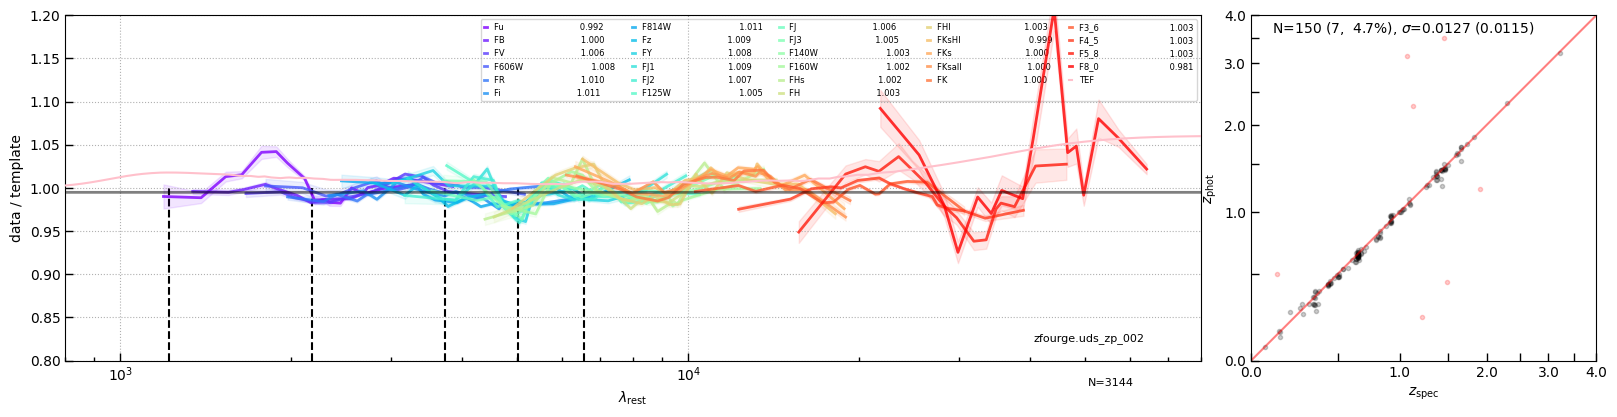

In [12]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter_ in range(NITER):
    print('Iteration: ', iter_)
    
    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    
    self.iterate_zp_templates(
        idx=self.idx[clip],
        update_templates=False, # (iter_ > 0), 
        update_zeropoints=True,
        iter=iter_,
        n_proc=8, 
        save_templates=False,
        error_residuals=False, 
        NBIN=NBIN,
        get_spatial_offset=False
    )

### Now fit the whole catalog

In [13]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

Set sys_err = 0.03 (positive=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:36<00:00, 13.90it/s]


Compute best fits
fit_best: 1.1 s (n_proc=1,  NOBJ=3146)
Fit 38.1 s (n_proc=8, NOBJ=3207)


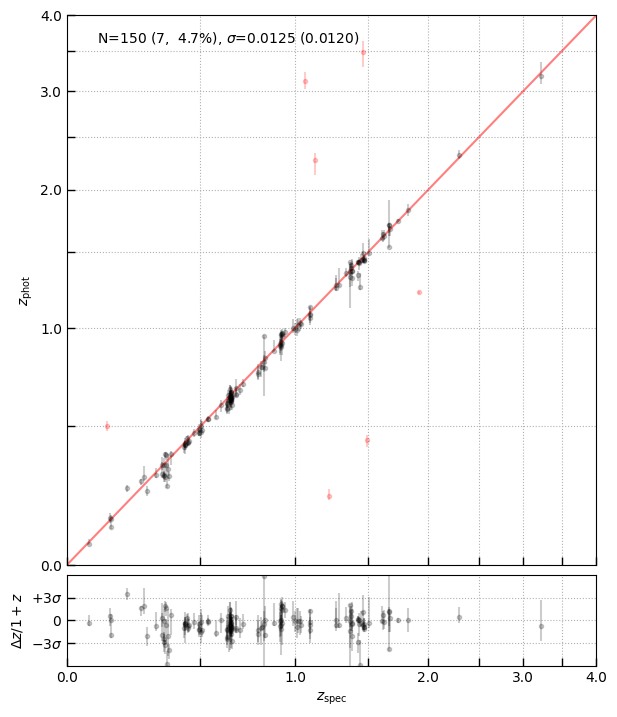

In [24]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [25]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
warnings.simplefilter('ignore', category=RuntimeWarning)

zout, hdu = self.standard_output(
    simple=False, 
    rf_pad_width=0.5,
    rf_max_err=2, 
    prior=True,
    beta_prior=True, 
    absmag_filters=[], 
    extra_rf_filters=[]
)

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 1.6 s (n_proc=1,  NOBJ=3146)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3146/3146 [00:11<00:00, 276.90it/s]


Text(0, 0.5, '$(U-V)_0$')

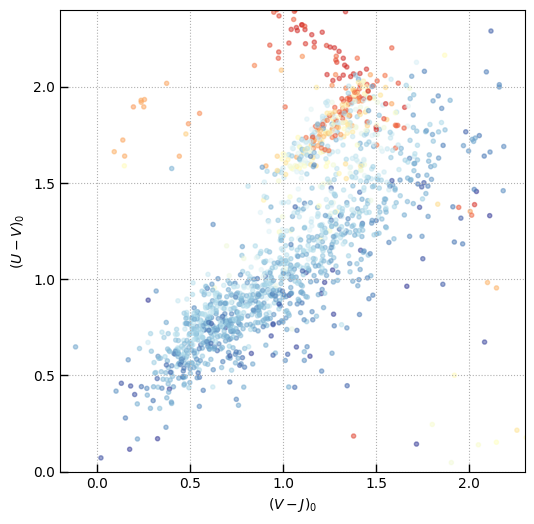

In [26]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel], 
            vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')    

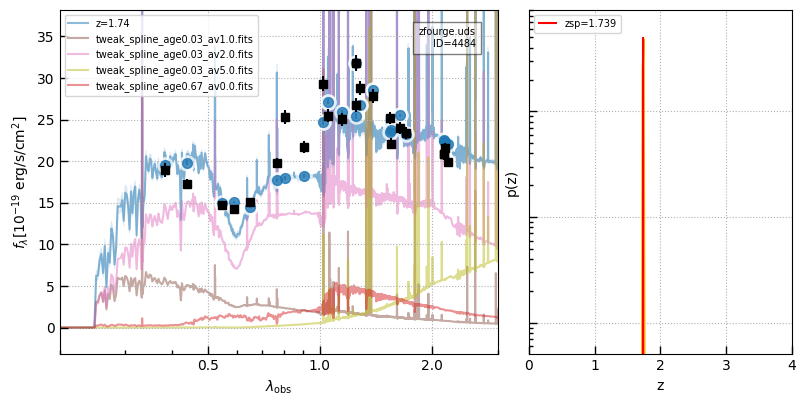

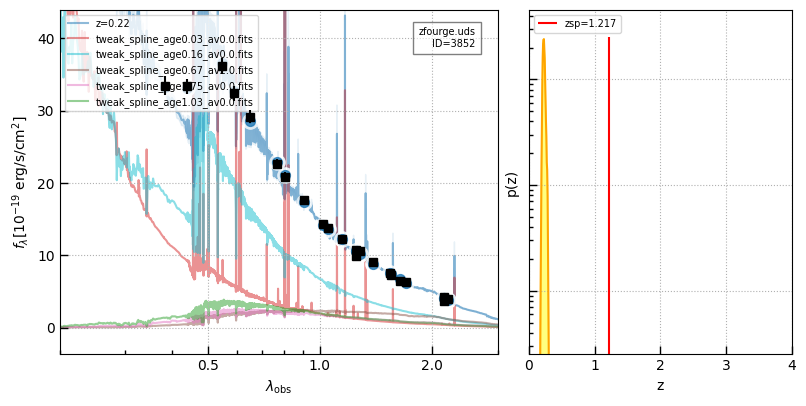

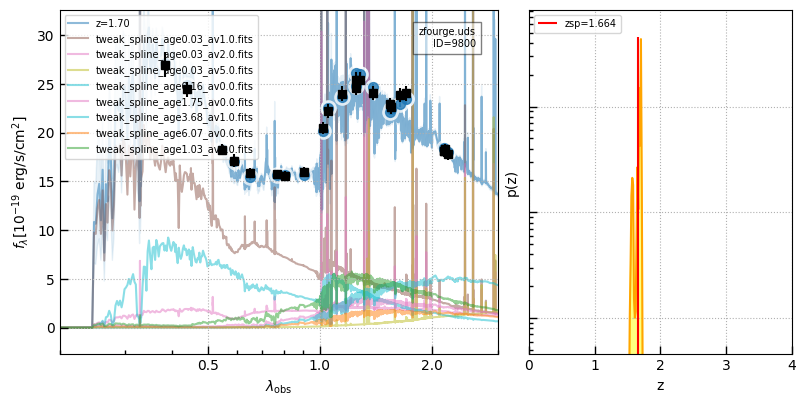

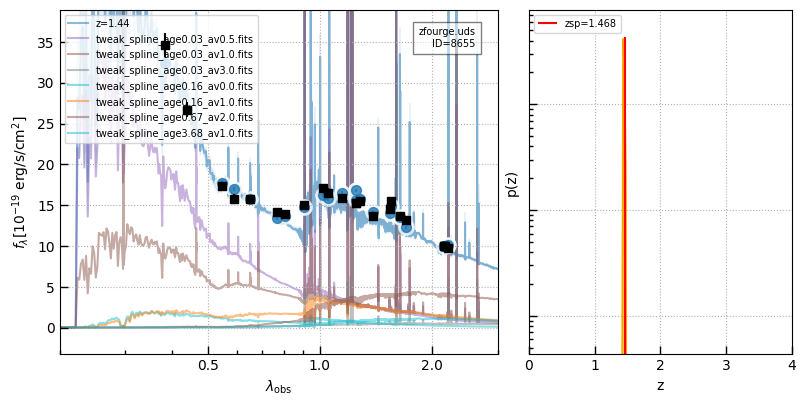

In [27]:
# Show brightest objects with z_spec > 1

ifilter = self.flux_columns[np.argmin((self.lc - 8140)**2)]

imag = params['PRIOR_ABZP'] - 2.5*np.log10(self.cat[ifilter])
sel = (self.ZSPEC > 1.1)

so = np.argsort(imag[sel])
ids = self.OBJID[sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

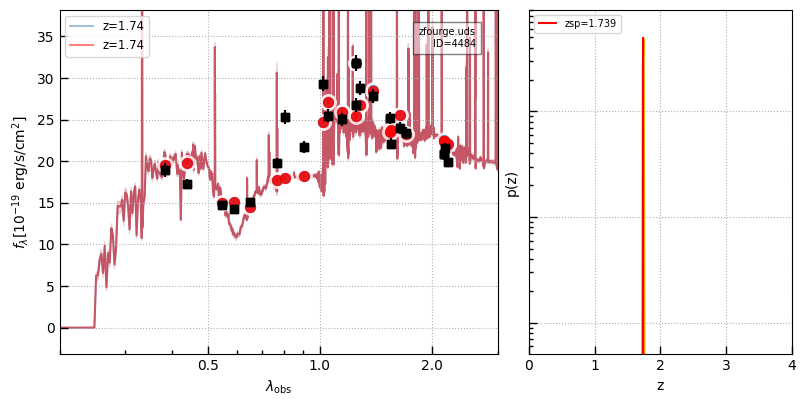

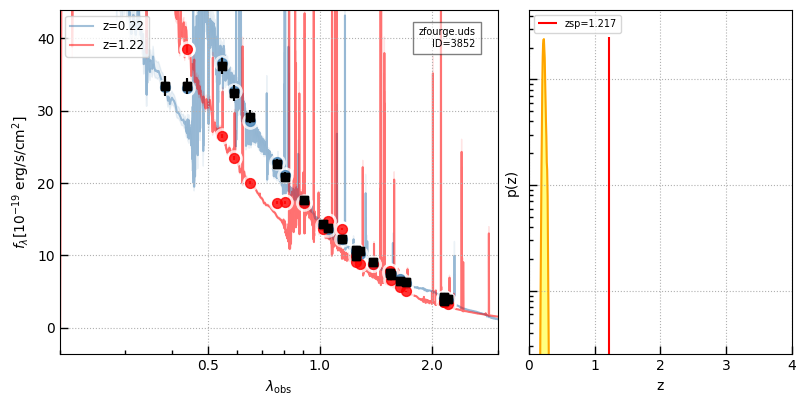

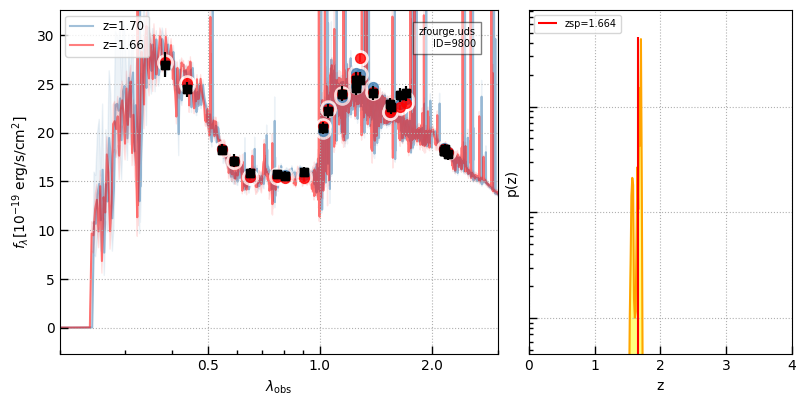

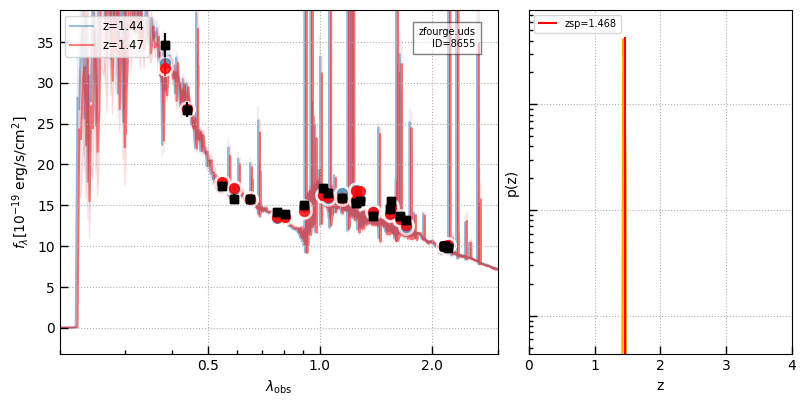

In [28]:
# Compare forced fit at z_spec
for i in range(4):
    ix = np.where(self.OBJID == ids[i])[0][0]
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], 
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = self.show_fit(ids[i], xlim=[0.2, 3], axes=axes,
                        zshow=self.ZSPEC[ix], 
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')

## `zout` properties

In [29]:
zout.meta

OrderedDict([('version', ('0.7.5.dev2+g292302a.d20241025', 'Eazy-py version')),
             ('prior', (True, 'Prior applied (templates/prior_K_TAO.dat)')),
             ('betprior', (True, 'Beta prior applied')),
             ('fitter', ('nnls', 'Optimization method for template fits')),
             ('SYS_ERR', 0.03),
             ('TEMP_ERR_FILE', 'templates/uvista_nmf/template_error_10.def'),
             ('TEMP_ERR_A2', 0.2),
             ('PRIOR_FILTER', 255),
             ('PRIOR_ABZP', 25),
             ('IGM_SCALE_TAU', 1.0),
             ('APPLY_IGM', 'y'),
             ('TEMPLATES_FILE',
              'templates/spline_templates_v2/tweak_spline.param'),
             ('RENORM_TEMPLATES', 'y'),
             ('HESS_THRESHOLD', 1),
             ('TEMPL000', 'tweak_spline_age0.01_av0.0.fits'),
             ('TEMPL001', 'tweak_spline_age0.01_av0.5.fits'),
             ('TEMPL002', 'tweak_spline_age0.03_av0.0.fits'),
             ('TEMPL003', 'tweak_spline_age0.03_av0.5.fits'),
   

In [30]:
zout.info()

<GTable length=3207>
    name      dtype  shape       unit       format        description            class     n_bad
------------ ------- ----- ---------------- ------ -------------------------- ------------ -----
          id   int64                                                                Column     0
          ra float64                                                                Column     0
         dec float64                                                                Column     0
      z_spec float64                                                          MaskedColumn  3055
    nusefilt   int64                                                                Column     0
        z_ml float32                                                                Column     0
   z_ml_chi2 float32                                                                Column     0
   z_ml_risk float32                                                                Column     0
      lc_

# Save / restore state with HDF5

In [31]:
try:
    import h5py
except:
    ! pip install h5py
    
import eazy.hdf5
eazy.hdf5.write_hdf5(self, h5file=self.param['MAIN_OUTPUT_FILE'] + '.h5')

h5: create file zfourge.uds.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: fit/fit_coeffs
h5: templates/tweak_spline_age0.01_av0.0.fits
h5: templates/tweak_spline_age0.01_av0.5.fits
h5: templates/tweak_spline_age0.03_av0.0.fits
h5: templates/tweak_spline_age0.03_av0.5.fits
h5: templates/tweak_spline_age0.03_av1.0.fits
h5: templates/tweak_spline_age0.03_av2.0.fits
h5: templates/tweak_spline_age0.03_av3.0.fits
h5: templates/tweak_spline_age0.03_av5.0.fits
h5: templates/tweak_spline_age0.16_av0.0.fits
h5: templates/tweak_spline_age0.16_av1.0.fits
h5: templates/tweak_spline_age0.16_av2.0.fits
h5: templates/tweak_spline_age0.67_av0.0.fits
h5: templates/tweak_spline_age0.67_av1.0.fits
h5: templates/tweak_spline_age0.67_av2.0.fits
h5: templates/tweak_spline_age1.75_av0.0.fits
h5: templates/tweak_spline_age1

## Initialize from HDF5

In [32]:
import eazy.hdf5
new = eazy.hdf5.initialize_from_hdf5(h5file=params['MAIN_OUTPUT_FILE'] + '.h5')

Read default param file: /Users/gbrammer/miniconda3/envs/py310-eazy/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 3207
F8_0 e_F8_0 ( 21): IRAC/irac_tr4_2004-08-09.dat
F5_8 e_F5_8 ( 20): IRAC/irac_tr3_2004-08-09.dat
F4_5 e_F4_5 ( 19): IRAC/irac_tr2_2004-08-09.dat
F3_6 e_F3_6 ( 18): IRAC/irac_tr1_2004-08-09.dat
FKs e_FKs (255): FOURSTAR/Ks_cam_optics_sky.txt
FKsHI e_FKsHI (269): VLT/hawki_k_ETC.dat
FJ1 e_FJ1 (249): FOURSTAR/J1_cam_optics_sky.txt
FJ2 e_FJ2 (250): FOURSTAR/J2_cam_optics_sky.txt
FJ3 e_FJ3 (251): FOURSTAR/J3_cam_optics_sky.txt
FHs e_FHs (254): FOURSTAR/Hshort_cam_optics_sky.txt
FHl e_FHl (253): FOURSTAR/Hlong_cam_optics_sky.txt
Fu e_Fu ( 88): megaprime/cfht_mega_u_cfh9301.dat
FB e_FB (122): UKIDSS/B_qe.txt
FV e_FV ( 79): COSMOS/SUBARU_filter_V.txt
FR e_FR (123): UKIDSS/R_qe.txt
Fi e_Fi (124): UKIDSS/i_qe.txt
Fz e_Fz (125): UKIDSS/z_qe.txt
FY e_FY (266): VLT/hawki_y_ETC.dat
FJ e_FJ (263): UKIDSS/Table04_online.dat
FH e_FH (26

511it [00:00, 1785.08it/s]


h5: read tweak_spline_age0.01_av0.0.fits
h5: read tweak_spline_age0.01_av0.5.fits
h5: read tweak_spline_age0.03_av0.0.fits
h5: read tweak_spline_age0.03_av0.5.fits
h5: read tweak_spline_age0.03_av1.0.fits
h5: read tweak_spline_age0.03_av2.0.fits
h5: read tweak_spline_age0.03_av3.0.fits
h5: read tweak_spline_age0.03_av5.0.fits
h5: read tweak_spline_age0.16_av0.0.fits
h5: read tweak_spline_age0.16_av1.0.fits
h5: read tweak_spline_age0.16_av2.0.fits
h5: read tweak_spline_age0.67_av0.0.fits
h5: read tweak_spline_age0.67_av1.0.fits
h5: read tweak_spline_age0.67_av2.0.fits
h5: read tweak_spline_age1.75_av0.0.fits
h5: read tweak_spline_age1.75_av1.0.fits
h5: read tweak_spline_age3.68_av0.0.fits
h5: read tweak_spline_age3.68_av1.0.fits
h5: read tweak_spline_age6.07_av0.0.fits
h5: read tweak_spline_age1.03_av0.0.fits
fit_best: 1.0 s (n_proc=1,  NOBJ=3146)


In [36]:
# Verify things are the same
assert(np.allclose(self.fnu, new.fnu))
assert(np.allclose(self.ok_data, new.ok_data))
try:
    assert(np.allclose(self.efnu_orig, new.efnu_orig))
except AssertionError:
    # Missing data might be represented a bit differently
    assert(np.allclose(self.efnu_orig[self.ok_data], new.efnu_orig[self.ok_data]))

assert(np.allclose(self.efnu[self.ok_data], new.efnu[self.ok_data]))
# assert(np.allclose(self.prior_mags, new.prior_mags))
assert(np.allclose(self.zml, new.zml))
assert(np.allclose(self.zbest, new.zbest))
try:
    assert(np.allclose(self.lnp, new.lnp, rtol=1.e-2))
except AssertionError:
    self.compute_lnp(prior=self.ZML_WITH_PRIOR,
                     beta_prior=self.ZML_WITH_BETA_PRIOR) 
    
    assert(np.allclose(self.lnp, new.lnp, rtol=1.e-2))

    

print('Made it to the end, everything is the same!')

Made it to the end, everything is the same!


## Tool for visualizing SEDs straight from HDF5

The `eazy.hdf5.Viewer` object provides a tool for plotting object SEDs without having to initialize a full `eazy.photoz.PhotoZ` object.  This may be useful for very large catalogs, as HDF5 handles the array access for large, 
memory-intensive arrays without having to load lots of things into memory.

OrigObj chi2 = 11.71857
NewObj  chi2 = 11.71857
Viewer  chi2 = 11.71857


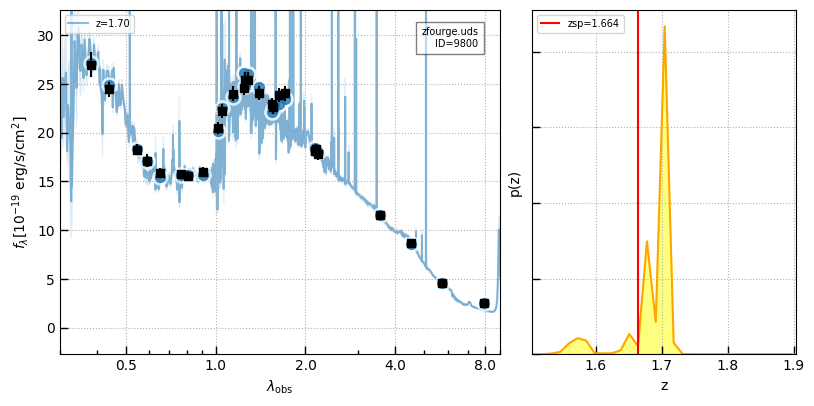

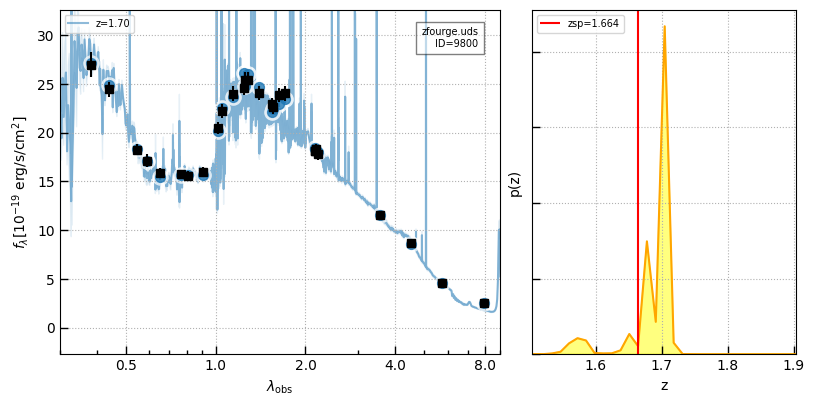

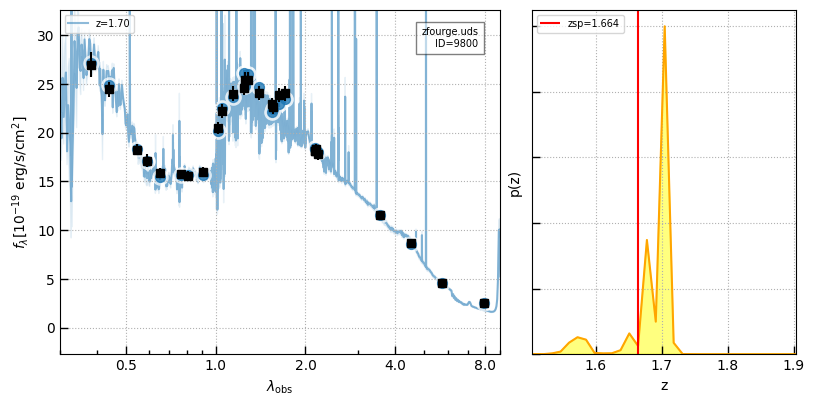

In [37]:
view = eazy.hdf5.Viewer(self.param['MAIN_OUTPUT_FILE'] + '.h5', verbose=False)

# Original object
s0 = self.show_fit(ids[2])

# The new PhotoZ object
s1 = new.show_fit(ids[2])

# The Viewer object
sv = view.show_fit(ids[2])

zph = s0[1]['z']

for _, label in zip([s0, s1, sv], ['OrigObj', 'NewObj', 'Viewer']):
    _[0].axes[1].set_xlim(zph-0.2, zph+0.2)
    print(f"{label:7} chi2 = {_[1]['chi2']:.5f}")

In [39]:
# try:
#     import plotly

#     ## plotly viewer
#     kws = dict(vertical=False, show=True)

#     # Original object
#     f0 = self.show_fit_plotly(ids[2], **kws)

#     # The new PhotoZ object
#     f1 = new.show_fit_plotly(ids[2], **kws)

#     # The Viewer object
#     fv = view.show_fit_plotly(ids[2], **kws)
# except:
#     print('`plotly` not installed')
    

# Visualization tool

Interactive tool added February 2022 for exploring the catalog and photo-z outputs with [Plotly/Dash](https://plotly.com/dash/).


In [40]:
try:
    import jupyter_dash
except ImportError:
    ! pip install dash jupyter-dash Werkzeug==2.0.3

In [47]:
import eazy.visualization
from importlib import reload
reload(eazy.visualization)

zout['jh'] = (-2.5*np.log10(self.cat['FJ1']/self.cat['FHs'])) #.filled(-1.)
zout['hk'] = (-2.5*np.log10(self.cat['FHs']/self.cat['FKs'])) #.filled(-1.)

bband = self.flux_columns[np.nanargmin((self.lc - 4500)**2)]
zband = self.flux_columns[np.nanargmin((self.lc - 9000)**2)]
zout['Bz'] = (-2.5*np.log10(self.cat[bband]/self.cat[zband])) #.filled(-1.)
zout['zK'] = (-2.5*np.log10(self.cat[zband]/self.cat['FKs'])) #.filled(-1.)

extra_plots = {
               'JH-redshift': ('z_phot','jh','z<sub>phot</sub>', '(J1-Hs)<sub>obs</sub>', (0, 4), (-0.1, 1.9)),
               'HK-redshift': ('z_phot','hk','z<sub>phot</sub>', '(Hs-Ks)<sub>obs</sub>', (0, 4), (-0.1, 1.9)),
               'BzK': ('Bz','zK',f'{bband} - {zband}', f'{zband} - K<sub>s</sub>', (-0.5, 5), (-0.5, 5)),
              }

for c in ['jh','hk', 'zK','Bz']:
    if hasattr(zout[c], 'mask'):
        zout[c].fill_value = -1.
    
sel = (zf['Use'] > -1)

vis = eazy.visualization.EazyExplorer(self, zout, extra_plots=extra_plots, 
                                      selection=sel)

if 1:
    app = vis.make_dash_app(
        server_mode='inline',
        app_type='dash',
        plot_height=450,
        infer_proxy=os.getcwd().startswith('/content')
    )


## static view

![static_viewer](dash_viewer.png)


In [48]:
# Run host locally
if 0:
    app = vis.make_dash_app(server_mode='external', plot_height=500, 
                        infer_proxy=os.getcwd().startswith('/content'))